# **Recommendation System: Rekomendasi Novel Bebasis Konten**
---

# Import Libary

In [5]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# External Tools & API
import kagglehub
import requests

# Text Feature Extraction & Similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Model Evaluation
from sklearn.metrics import precision_recall_fscore_support


# Data Understanding

memahami informasi dalam data dan memnetukan kualitas dari data

## Data Loading

In [6]:
path = kagglehub.dataset_download("devdope/200k-spotify-songs-light-dataset")
df = pd.read_csv(path + "/light_spotify_dataset.csv")

df.head()

,artist,song,emotion,variance,Genre,Release Date,Key,Tempo,Loudness,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,Acousticness,Instrumentalness
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,31,78,56,60,3,31,7,0
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,59,36,52,38,2,7,68,0
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,50,78,85,97,3,8,20,2
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,52,76,50,89,3,32,3,0


In [7]:
df.columns = df.columns.str.lower()

## Exploratory Data Analysis (EDA)

Menginvestigasi data untuk memahami karakteristik data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236988 entries, 0 to 236987
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist            236988 non-null  object 
 1   song              236980 non-null  object 
 2   emotion           236988 non-null  object 
 3   variance          236988 non-null  float64
 4   genre             236988 non-null  object 
 5   release date      236988 non-null  int64  
 6   key               236988 non-null  object 
 7   tempo             236988 non-null  int64  
 8   loudness          236988 non-null  float64
 9   explicit          236988 non-null  object 
 10  popularity        236988 non-null  int64  
 11  energy            236988 non-null  int64  
 12  danceability      236988 non-null  int64  
 13  positiveness      236988 non-null  int64  
 14  speechiness       236988 non-null  int64  
 15  liveness          236988 non-null  int64  
 16  acousticness      23

In [9]:
print("Jumlah kolom:", len(df.columns))

Jumlah kolom: 18


In [10]:
print("Jumlah baris:", len(df))

Jumlah baris: 236988


In [11]:
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
print("Jumlah Fitur Numerik:", len(numerical_features))
print("Fitur Numerik:", numerical_features)

categorical_features = df.select_dtypes(include=[object]).columns.tolist()
print("Jumlah Fitur Kategorikal:", len(categorical_features))
print("Fitur Kategorikal:", categorical_features)

Jumlah Fitur Numerik: 12
Fitur Numerik: ['variance', 'release date', 'tempo', 'loudness', 'popularity', 'energy', 'danceability', 'positiveness', 'speechiness', 'liveness', 'acousticness', 'instrumentalness']
Jumlah Fitur Kategorikal: 6
Fitur Kategorikal: ['artist', 'song', 'emotion', 'genre', 'key', 'explicit']


In [12]:
print("Jumlah nilai hilang:\n", df.isnull().sum())

Jumlah nilai hilang:
 artist              0
song                8
emotion             0
variance            0
genre               0
release date        0
key                 0
tempo               0
loudness            0
explicit            0
popularity          0
energy              0
danceability        0
positiveness        0
speechiness         0
liveness            0
acousticness        0
instrumentalness    0
dtype: int64


In [13]:
df.dropna(inplace=True)
print("Jumlah data setelah menghapus nilai hilang:", len(df))

Jumlah data setelah menghapus nilai hilang: 236980


In [14]:
print("Jumlah nilai duplikat:", df.duplicated().sum())

Jumlah nilai duplikat: 2


In [15]:
df.drop_duplicates(inplace=True)
print("Jumlah data setelah menghapus nilai duplikat:", len(df))

Jumlah data setelah menghapus nilai duplikat: 236978


In [16]:
print(20 * "=" + " Statistik Deskriptif Fitur Numerik " + 20 * "=")
display(df[numerical_features].describe())

==================== Statistik Deskriptif Fitur Numerik ====================


,variance,release date,tempo,loudness,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
count,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000,236978.000000
mean,0.658930,2008.472660,120.610386,-8.038588,40.004106,62.369152,59.127780,47.657496,11.748107,19.905080,26.156242,5.439496
std,0.320737,14.756281,28.966076,3.842097,18.769637,22.082970,17.069165,23.801894,12.443722,16.550773,29.046874,17.661489
min,-1.000000,1900.000000,33.000000,-46.770000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,0.833514,2002.000000,97.000000,-9.890000,27.000000,48.000000,48.000000,29.000000,4.000000,10.000000,2.000000,0.000000
50%,0.833514,2015.000000,120.000000,-7.190000,39.000000,64.000000,60.000000,47.000000,6.000000,13.000000,14.000000,0.000000
75%,0.833514,2019.000000,140.000000,-5.370000,52.000000,80.000000,72.000000,66.000000,16.000000,25.000000,44.000000,0.000000
max,1.000000,2024.000000,200.000000,3.740000,100.000000,100.000000,99.000000,99.000000,97.000000,100.000000,100.000000,100.000000


<Figure size 1200x600 with 0 Axes>

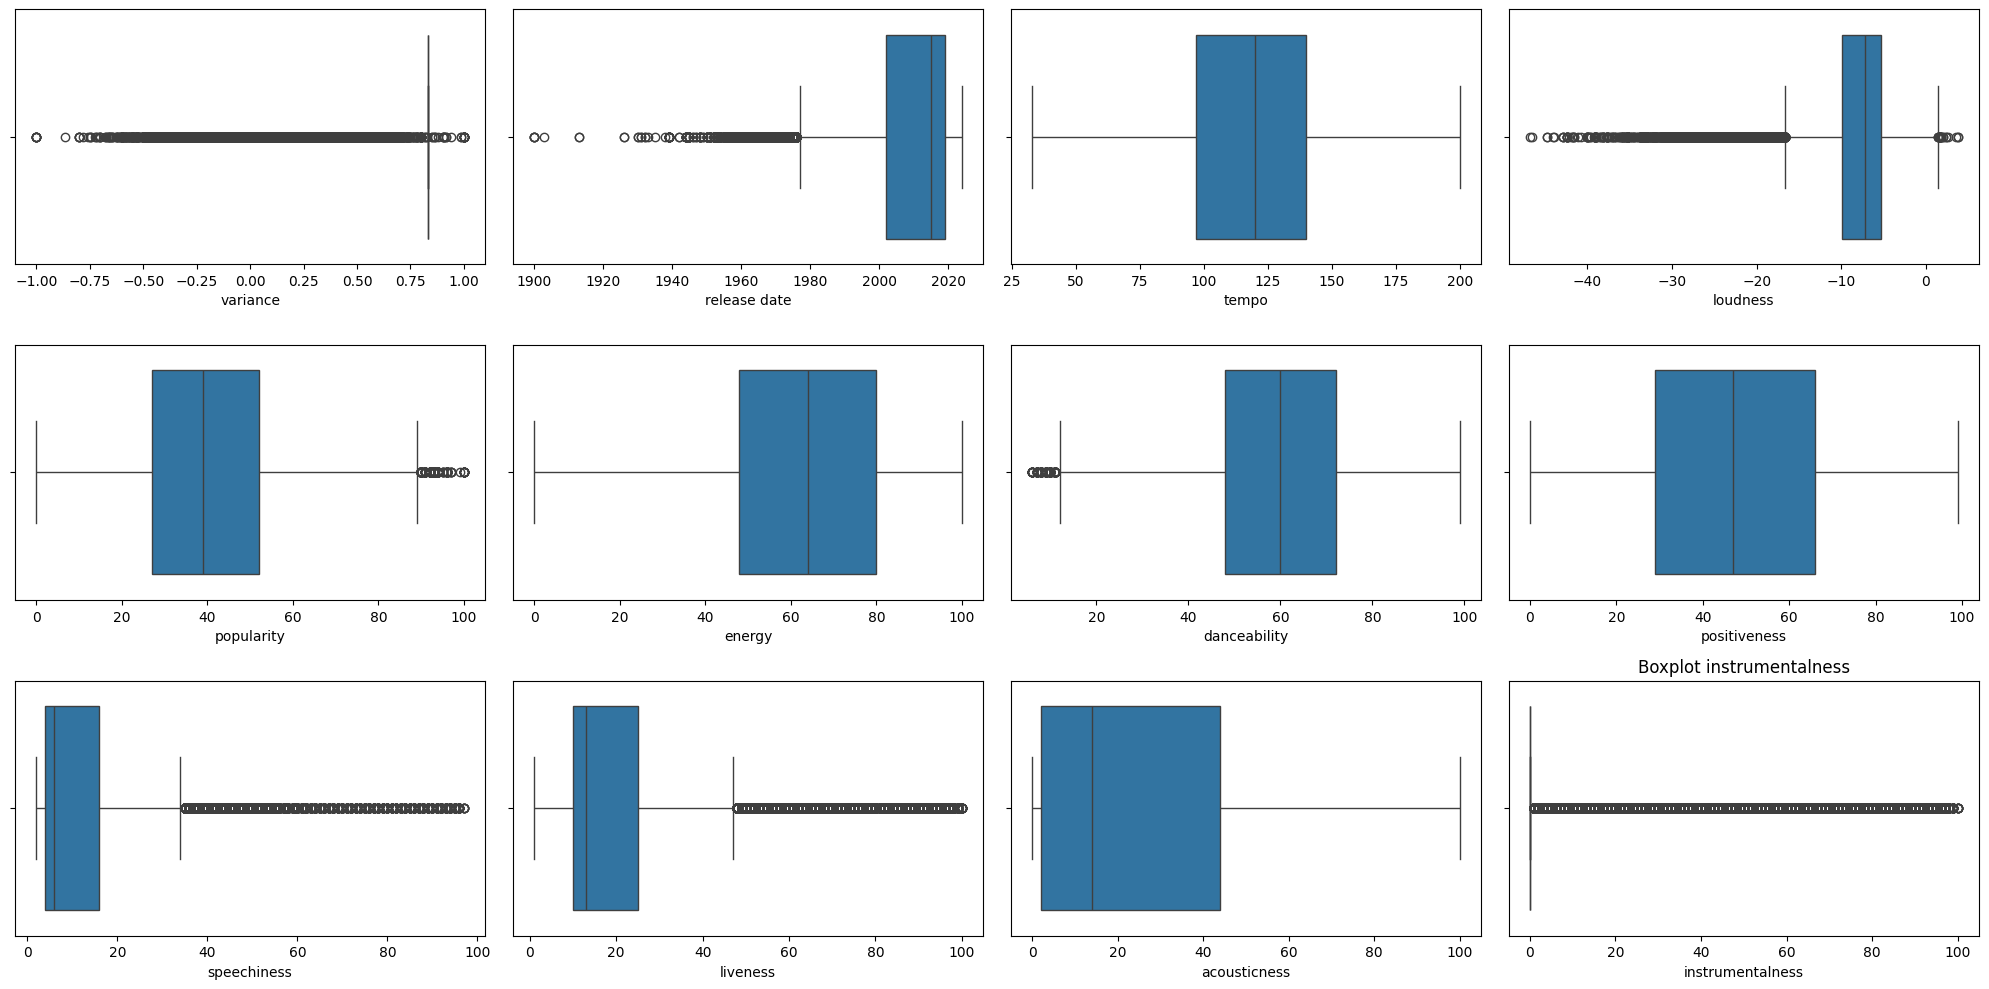

In [17]:
plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(3, 4, figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=ax[i // 4, i % 4])
    plt.title(f"Boxplot {feature}")
    plt.xlabel(feature)
plt.tight_layout()
plt.show()

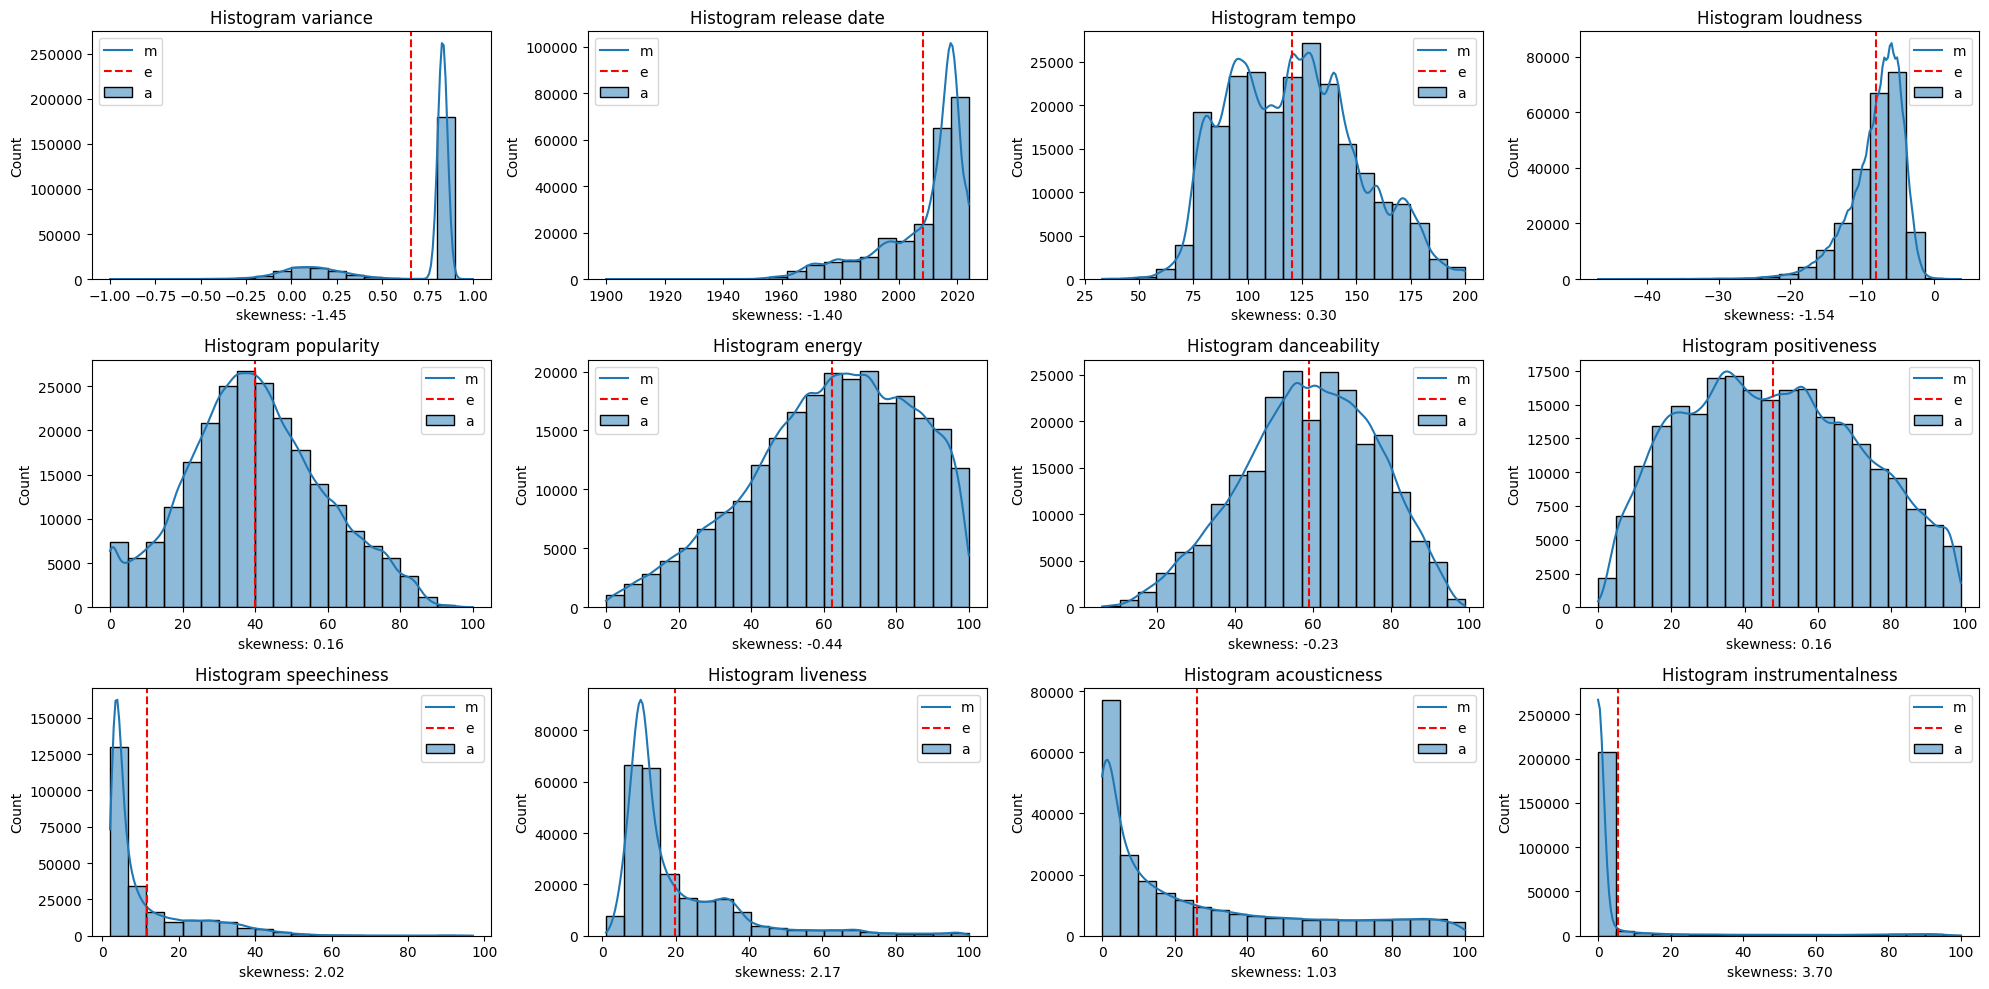

In [18]:
plt.figure(figsize=(20, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(df[feature], bins=20, kde=True)
    mean = df[feature].mean()
    skewness = df[feature].skew()
    plt.axvline(mean, color='red', linestyle='--', label='Mean')
    plt.title(f"Histogram {feature}")
    plt.xlabel(f"skewness: {skewness:.2f}")
    plt.legend(f"mean: {mean:.2f}")
plt.tight_layout()
plt.show()

In [19]:
print(20 * "=" + " Statistik Deskriptif Fitur Kategorikal " + 20 * "=")
display(df[categorical_features].describe())

==================== Statistik Deskriptif Fitur Kategorikal ====================


,artist,song,emotion,genre,key,explicit
count,236978,236978,236978,236978,236978,236978
unique,30607,159729,10,2562,24,2
top,Genius English Translations,Home,joy,"Unknown,Unknown,Unknown",C Maj,No
freq,1604,126,91528,50016,21155,161020


In [20]:
for feature in categorical_features:
    print(10 * "=" + f" {feature} " + 10 * "=")
    print(df[feature].unique(), "\n")
    print("Jumlah unik:", df[feature].nunique(), "\n")

========== artist ==========
['ABBA' 'Ace Of Base' 'Adam Sandler' ... '  (Dima Bilan)' '  (Ani Lorak)'
 '  (Alla Pugacheva) & 50 Cent'] 

Jumlah unik: 30607 

========== song ==========
["She's My Kind Of Girl" 'Andante, Andante' 'As Good As New' ...
 'El Diablo' 'Shady Lady' 'Позови меня P.I.M.P'] 

Jumlah unik: 159729 

========== emotion ==========
['joy' 'love' 'sadness' 'anger' 'surprise' 'fear' 'angry' 'pink' 'True'
 'thirst'] 

Jumlah unik: 10 

========== genre ==========
['pop' 'comedy' 'rock' ... '90s,dance,House' 'sad,Love,slow'
 'noise rock,Unknown,Unknown'] 

Jumlah unik: 2562 

========== key ==========
['F Maj' 'A# Maj' 'E Maj' 'C Maj' 'A Maj' 'G# Maj' 'C# Maj' 'G Maj'
 'D Maj' 'C# min' 'C min' 'E min' 'B min' 'D min' 'F# min' 'A min' 'B Maj'
 'F# Maj' 'G min' 'D# Maj' 'A# min' 'F min' 'D# min' 'G# min'] 

Jumlah unik: 24 

========== explicit ==========
['No' 'Yes'] 

Jumlah unik: 2 



In [21]:
# Pastikan semua nilai genre jadi list
df['genre'] = df['genre'].apply(
    lambda x: x.split(',') if isinstance(x, str)
    else x if isinstance(x, list)
    else []
)

# Ambil semua genre unik
unique_genres = set()
for genres in df['genre']:
    unique_genres.update([g.strip() for g in genres])  # strip() untuk menghapus spasi ekstra

print("Jumlah genre unik:", len(unique_genres))
print("Genre unik:")
display(unique_genres)


Jumlah genre unik: 2337
Genre unik:


{'Great gospel voice',
 'football',
 'Started from the bottom now we way up',
 'witch house',
 'philippines',
 'blues',
 'modern',
 'Glasgow Rangers',
 'heavy stuff',
 'theme',
 'country rock',
 'Afrikan Boy',
 'title is declarative',
 'baby making music',
 'Traditional Country',
 'recommended to rwitte',
 'rhythm and blues',
 'John Anderson',
 'Manchester',
 'sd',
 'praise & worship',
 'grandmix',
 'nick and norah',
 'Don Williams',
 'new rave',
 'melbourne sound',
 'wsc 3 final',
 'cook',
 'miami',
 'post-rock',
 'funky house',
 'video game music',
 'Karol G',
 'electric chicago blues',
 'aa',
 'cold',
 'bajki',
 'wedding',
 'new jack swing',
 'minimalism',
 'bad moms',
 'wave',
 'KDrama',
 'nice',
 'harmonica',
 'hymns',
 'niggacore',
 'conan',
 'Rock Band Network',
 'radioparadise',
 'Norway',
 'my little pony',
 'fav',
 'mash-up',
 'answer songs',
 'donk',
 'nostalgia',
 'shandolyn',
 'melancholy',
 'Prima Donna',
 '21st century in music',
 'midwest emo',
 'mistagged track',
 'sax

<ipython-input-22-afcf601c5d9a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data.index, x=data.values, palette='viridis')
<ipython-input-22-afcf601c5d9a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data.index, x=data.values, palette='viridis')
<ipython-input-22-afcf601c5d9a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=data.index, x=data.values, palette='viridis')


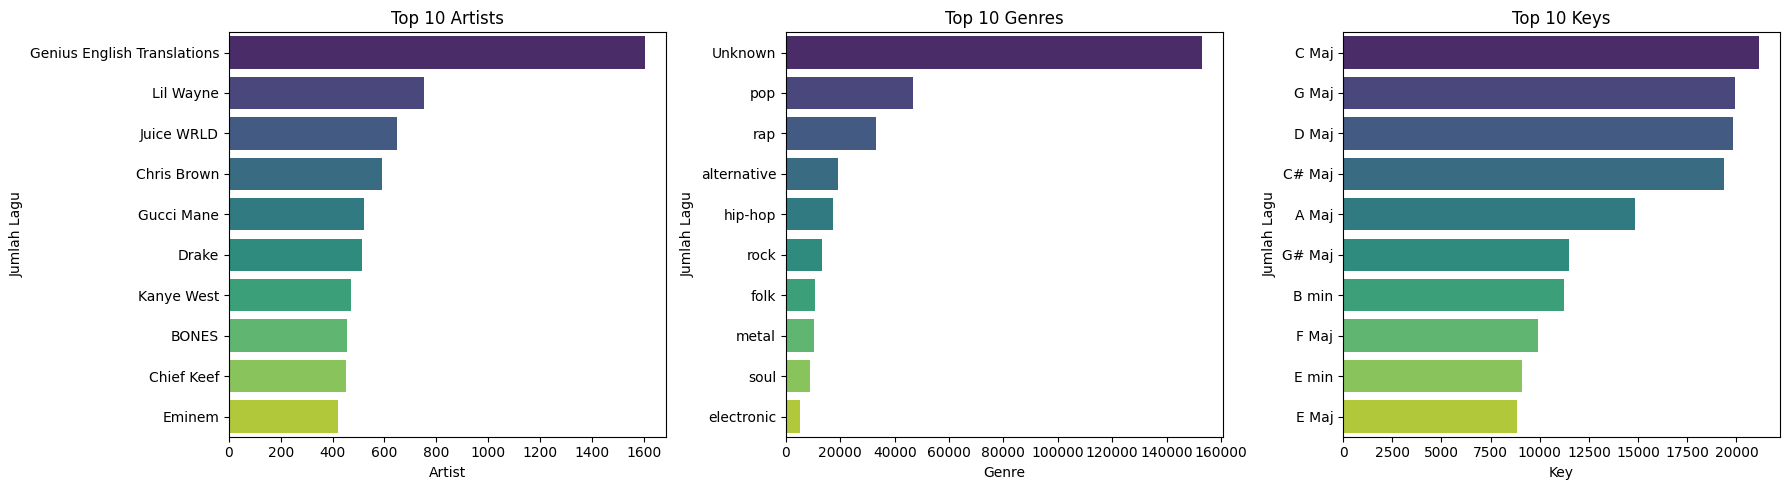

In [22]:
top_10_dict = {
    'Artist': df['artist'].value_counts().head(10),
    'Genre': df['genre'].explode().value_counts().head(10),
    'Key': df['key'].value_counts().head(10)
}

plt.figure(figsize=(18, 5))
for i, (label, data) in enumerate(top_10_dict.items()):
    plt.subplot(1, 3, i + 1)
    sns.barplot(y=data.index, x=data.values, palette='viridis')
    plt.title(f"Top 10 {label}s")
    plt.xlabel(label)
    plt.ylabel("Jumlah Lagu")
plt.tight_layout()
plt.show()

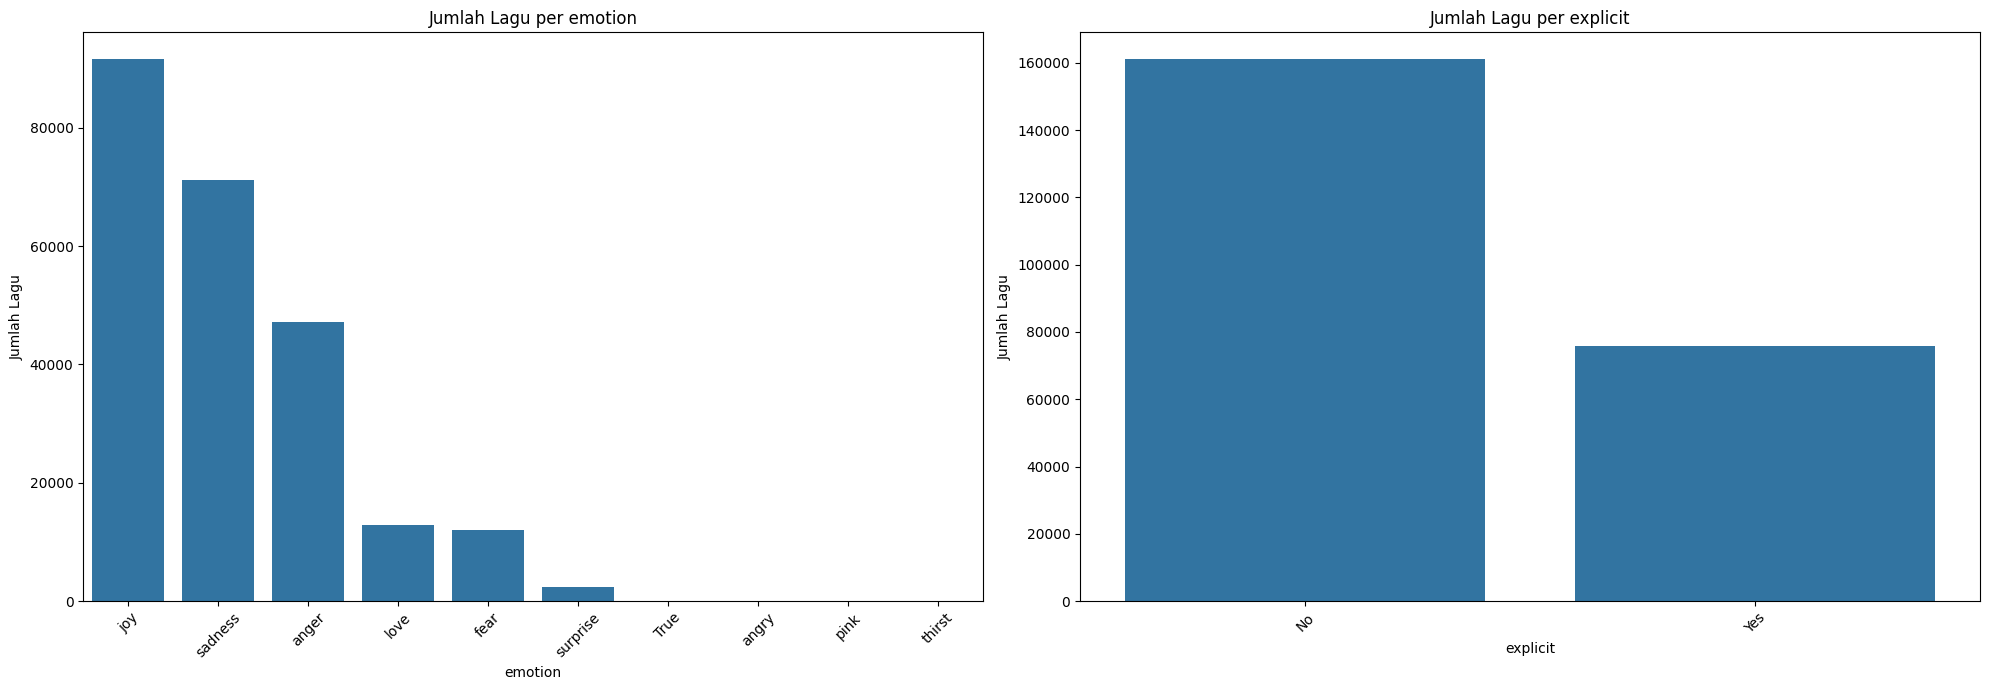

In [23]:
col_to_plot = ['emotion', 'explicit']

plt.figure(figsize=(20, 7))
for i, col in enumerate(col_to_plot):
    plt.subplot(1, 2, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Jumlah Lagu per {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah Lagu")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Data Preparation

In [24]:
df = df[~df['genre'].apply(lambda x: 'Unknown' in x)]
print("Jumlah data setelah menghapus genre 'Unknown':", len(df))

Jumlah data setelah menghapus genre 'Unknown': 185076


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185076 entries, 0 to 236854
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   artist            185076 non-null  object 
 1   song              185076 non-null  object 
 2   emotion           185076 non-null  object 
 3   variance          185076 non-null  float64
 4   genre             185076 non-null  object 
 5   release date      185076 non-null  int64  
 6   key               185076 non-null  object 
 7   tempo             185076 non-null  int64  
 8   loudness          185076 non-null  float64
 9   explicit          185076 non-null  object 
 10  popularity        185076 non-null  int64  
 11  energy            185076 non-null  int64  
 12  danceability      185076 non-null  int64  
 13  positiveness      185076 non-null  int64  
 14  speechiness       185076 non-null  int64  
 15  liveness          185076 non-null  int64  
 16  acousticness      185076 

In [26]:
df['text'] = (df['artist'] + ' ' + df['song'] + ' ' +
              df['emotion'] + ' ' + df['key'] + ' ' +
              df['genre'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x)))

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text'])

pd.DataFrame.sparse.from_spmatrix(
    tfidf_matrix,
    columns=vectorizer.get_feature_names_out(),
    index=df.song
)

,00,000,0000,00000,00007,0000ff,001,002,003,004,...,zwan,zwette,zwitch,zydrate,zygotic,zz,zzyzx,zzz,zzzonked,zzzz
song,,,,,,,,,,,,,,,,,,,,,
She's My Kind Of Girl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Andante, Andante",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
As Good As New,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bang-A-Boomerang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
This Songs Just Six Words Long,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
I Love Rocky Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Confessions Part III,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_matrix = scaler.fit_transform(df[numerical_features])

pd.DataFrame(
    num_matrix,
    columns=numerical_features,
    index=df.song
)

,variance,release date,tempo,loudness,popularity,energy,danceability,positiveness,speechiness,liveness,acousticness,instrumentalness
song,,,,,,,,,,,,
She's My Kind Of Girl,0.723810,0.919355,0.568862,0.807167,0.322917,0.78,0.537634,0.606061,0.010526,0.303030,0.07,0.00
"Andante, Andante",0.601111,0.645161,0.413174,0.713720,0.614583,0.36,0.494624,0.383838,0.000000,0.060606,0.68,0.00
As Good As New,0.650440,0.637097,0.634731,0.813106,0.520833,0.78,0.849462,0.979798,0.010526,0.070707,0.20,0.02
Bang,0.677500,0.604839,0.592814,0.866561,0.541667,0.76,0.473118,0.898990,0.010526,0.313131,0.03,0.00
Bang-A-Boomerang,0.677500,0.604839,0.592814,0.866561,0.541667,0.76,0.473118,0.898990,0.010526,0.313131,0.03,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
This Songs Just Six Words Long,0.916757,0.709677,0.700599,0.722629,0.375000,0.69,0.827957,0.979798,0.042105,0.090909,0.04,0.00
I Love Rocky Road,0.916757,0.669355,0.413174,0.747773,0.447917,0.73,0.827957,0.919192,0.147368,0.060606,0.43,0.00
Confessions Part III,0.916757,0.774194,0.287425,0.717284,0.593750,0.45,0.720430,0.484848,0.157895,0.262626,0.10,0.00


In [28]:
import scipy.sparse as sp

# 1) Buat sparse dari numeric
num_sparse = sp.csr_matrix(num_matrix)

# 2) Stack dengan benar, langsung ke CSR
combined_matrix = sp.hstack(
    [tfidf_matrix, num_sparse,],
    format='csr'
)

# sekarang combined_matrix sudah CSR dan bisa di-index langsung
print(combined_matrix)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3444156 stored elements and shape (185076, 38818)>
  Coords	Values
  (0, 870)	0.5021969881212686
  (0, 30500)	0.40943254568736487
  (0, 23389)	0.27815574867145654
  (0, 18927)	0.5051177651792634
  (0, 24526)	0.24996754384480593
  (0, 14222)	0.3733809067941689
  (0, 18292)	0.12359413225928063
  (0, 21169)	0.08980907455189663
  (0, 26623)	0.14970085003160397
  (0, 38806)	0.7238095238095238
  (0, 38807)	0.9193548387096779
  (0, 38808)	0.5688622754491018
  (0, 38809)	0.8071668976440308
  (0, 38810)	0.32291666666666663
  (0, 38811)	0.78
  (0, 38812)	0.5376344086021505
  (0, 38813)	0.6060606060606061
  (0, 38814)	0.010526315789473686
  (0, 38815)	0.30303030303030304
  (0, 38816)	0.07
  (1, 870)	0.3157673629759887
  (1, 21169)	0.05646942397774477
  (1, 26623)	0.09412769046382413
  (1, 1925)	0.9325045017297299
  (1, 20645)	0.13666568251227754
  :	:
  (185074, 38811)	0.76
  (185074, 38812)	0.6451612903225807
  (185074, 38813)	0.93939

# Modelling

In [29]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=100, metric='cosine', algorithm='brute')
model.fit(combined_matrix)

def song_recommendations(song_name: str, df: pd.DataFrame, combined_matrix = combined_matrix, model = model, k=3):
    if song_name not in df['song'].values:
        raise ValueError(f"Song '{song_name}' tidak ditemukan.")
    idx = df.index[df['song'] == song_name][0]

    distances, indices = model.kneighbors(combined_matrix[idx], n_neighbors=k+1)
    rec_idxs = [i for i in indices[0] if i != idx][:k]
    rec_dists = [distances[0][list(indices[0]).index(i)] for i in rec_idxs]

    recs = df.iloc[rec_idxs].copy().reset_index(drop=True)
    similarity_scores = [1 - d for d in rec_dists]
    recs['similarity_score'] = [f"{score * 100:.2f}%" for score in similarity_scores]
    return recs[['song', 'artist', 'genre', 'similarity_score']]

In [30]:
df.sample(1, random_state=42).iloc[0]

,93326
artist,State Champs
song,Around the World and Back
emotion,joy
variance,0.833514
genre,[pop]
release date,2024
key,E Maj
tempo,89
loudness,-6.17
explicit,No


In [31]:
song_recommendations(df.song.sample(1, random_state=42).iloc[0], df, k=5)

,song,artist,genre,similarity_score
0,No. 1,Rick Ross,[rap],90.80%
1,D.O.P.E.,Rick Ross,[rap],90.56%
2,Movin Bass,Tink,[hip-hop],90.13%
3,Nobody,Rick Ross,[rap],89.59%
4,Icon,Rick Ross,[rap],89.48%


In [44]:
def ndcg_score(recommend_func, df, ground_truth, k=5):
    def dcg(relevance_scores):
        return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores))

    total_ndcg = 0
    valid_queries = 0

    for query_song, relevant_songs in ground_truth.items():
        try:
            recs = recommend_func(query_song, df, k=k)
            recommended_songs = recs['song'].tolist()
            relevance = [1 if song in relevant_songs else 0 for song in recommended_songs]
            if any(relevance):
                ideal_relevance = sorted(relevance, reverse=True)
                ndcg = dcg(relevance) / dcg(ideal_relevance)
                total_ndcg += ndcg
                valid_queries += 1
        except ValueError:
            continue

    return total_ndcg / valid_queries if valid_queries > 0 else 0.0

In [43]:
ground_truth = {
    "All I Ask": [
        "Hello", "When We Were Young", "Someone Like You", "One and Only", "Remedy",
        "Chasing Pavements", "Turning Tables", "Set Fire to the Rain", "Easy On Me", "Love in the Dark"
    ]
}

score = ndcg_score(song_recommendations, df, ground_truth, k=5)
print(f"NDCG Score: {score:.4f}")

NDCG Score: 0.6797
